<a href="https://colab.research.google.com/github/asadian98/Deep-Learning-Course-EE25647/blob/HW3_Q2_SimpleRNN/HW3/HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

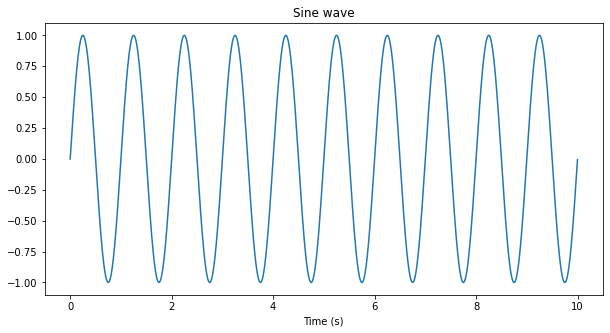

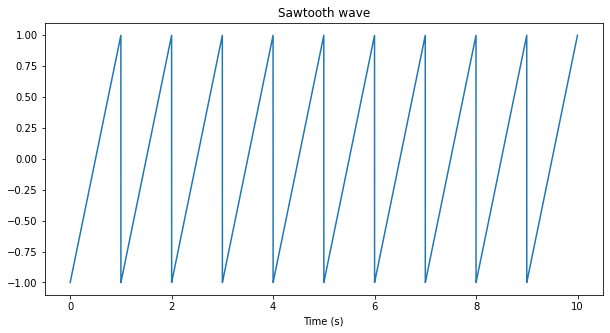

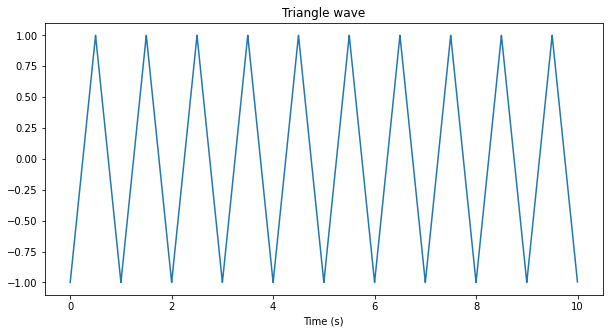

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

t = np.arange(0, 10, 0.001)
sine_wave = np.sin(2*np.pi*t)
sawtooth_wave = signal.sawtooth(2*np.pi*t)
triangle_wave = signal.sawtooth(2*np.pi*t, 0.5)

plt.figure(figsize=(10, 5))
plt.plot(t, sine_wave)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_wave)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_wave)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

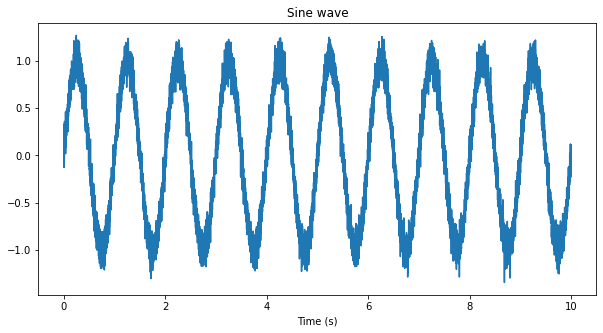

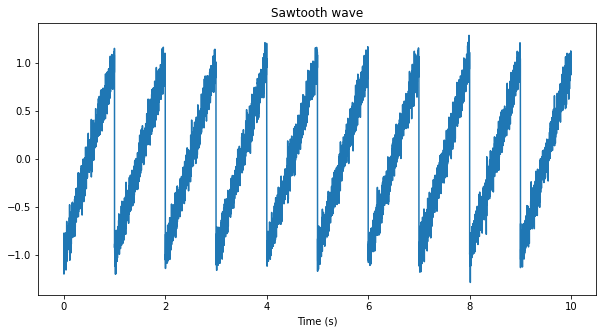

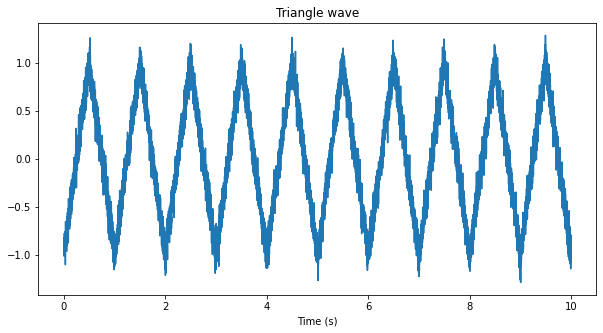

In [2]:
sine_noisy = sine_wave + np.random.normal(0,0.1,len(sine_wave))
sawtooth_noisy = sawtooth_wave + np.random.normal(0,0.1,len(sawtooth_wave))
triangle_noisy = triangle_wave + np.random.normal(0,0.1,len(triangle_wave))

plt.figure(figsize=(10, 5))
plt.plot(t, sine_noisy)
plt.title('Sine wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, sawtooth_noisy)
plt.title('Sawtooth wave')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, triangle_noisy)
plt.title('Triangle wave')
plt.xlabel('Time (s)')
plt.show()

In [3]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

# Prepare the input X and target Y
def get_XY(data_noisy, data, time_steps):
    rows_x = int(len(data) / time_steps)
    X = np.reshape(data_noisy, (rows_x, time_steps, 1))    
    Y = np.reshape(data, (rows_x, time_steps, 1))    
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_mse = []
    test_mse = []
    for i in range(len(trainY)):
      train_mse.append(mean_squared_error(trainY[i], train_predict[i]))
    for i in range(len(testY)):
      test_mse = math.sqrt(mean_squared_error(testY[i], test_predict[i]))
    # Print RMSE
    print('Train MSE: %.3f MSE' % (np.average(train_mse)))
    print('Test MSE: %.3f MSE' % (np.average(test_mse)))   

def plot_result(trainY, testY, train_predict, test_predict, Signal_name, std, Signal):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.plot(range(rows), Signal[0:len(predictions)], color='r')
    plt.axvline(x=len(trainY[0])*len(trainY), color='k')
    plt.legend(['Noisy', 'Denoised', 'Original'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel(Signal_name)
    plt.title('Noisy, Denoised and Original Values for {}, standard deviation = {}. The Red Line Separates The Training And Test Examples'.format(Signal_name, std))

def signalPower(x):
    return np.average(x**2)

def SNRsystem(inputSig, outputSig):
    noise = np.reshape(outputSig, (len(outputSig)*len(outputSig[0]), -1))-np.reshape(inputSig, (len(inputSig)*len(inputSig[0]), -1))
    
    powS = signalPower(outputSig)
    powN = signalPower(noise)
    return 10*np.log10((powS-powN)/powN)

def LossAccPlot(history):
  plt.figure()

  plt.plot(history.history['mean_squared_error'])
  plt.plot(history.history['val_mean_squared_error'])
  plt.title('Model MSE')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def create_RNN(lr, LSTM_flag):
    model = Sequential()

    if(LSTM_flag):
      model.add(LSTM(1000, input_shape=(1000,1), activation='tanh'))
    else:
      model.add(SimpleRNN(1000, input_shape=(1000,1), activation='tanh'))

    model.add(Dense(units=1000, activation='tanh'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics = ['mean_squared_error'])
    
    return model

def process(Signal, std, Signal_name, lr, batch_size, number_of_epochs, verbose, LSTM_flag):
  Signal_noisy = Signal + np.random.normal(0,std,len(Signal))

  train_noisy = Signal_noisy[0:int(0.7*len(Signal_noisy))]
  valid_noisy = Signal_noisy[int(0.7*len(Signal_noisy)):int(0.8*len(Signal_noisy))]
  test_noisy = Signal_noisy[int(0.8*len(Signal_noisy)):]

  train = Signal[0:int(0.7*len(Signal))]
  valid = Signal[int(0.7*len(Signal)):int(0.8*len(Signal))]
  test = Signal[int(0.8*len(Signal)):]

  time_steps = 1000
  x_train, y_train = get_XY(train_noisy, train, time_steps)
  x_valid, y_valid = get_XY(valid_noisy, valid, time_steps)
  x_test, y_test = get_XY(test_noisy, test, time_steps)
  
  if(verbose):
    model = create_RNN(lr = lr, LSTM_flag = LSTM_flag)
    history = model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=batch_size, validation_data = (x_valid, y_valid), verbose=1)

    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)

    # Mean square error
    print_error(y_train, y_test, train_predict, test_predict)

    plot_result(x_train, x_test, train_predict, test_predict, Signal_name, std, Signal)

    # Plot MSE for each epoch in training and validation
    LossAccPlot(history)

    SNR_train = SNRsystem(y_train, train_predict)
    SNR_x = SNRsystem(y_train, x_train)
    print("SNR was {}, SNR for training output: {} dB".format(SNR_x, SNR_train))
    SNR_test = SNRsystem(y_test, test_predict)
    SNR_test_x = SNRsystem(y_test, x_test)
    print("SNR was {}, SNR for training output: {} dB".format(SNR_test_x, SNR_test))

  else:
    estimator = KerasRegressor(build_fn=create_RNN, verbose=0)

    # define the grid search parameters
    lr = [0.001, 0.01, 0.1, 0.2, 0.3]
    batch_size = [1, 2, 3, 4, 5, 6, 7]
    epochs = [5, 10, 15, 20, 25, 30, 35]
    LSTM_flag = [0, 1]
    param_grid = dict(lr=lr, batch_size=batch_size, epochs = epochs, LSTM_flag = LSTM_flag)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(x_train, y_train)

    return grid_result

In [4]:
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.001, batch_size = 1, number_of_epochs = 10, verbose = True, LSTM_flag = 1)

Epoch 1/10
3/7 [===========>..................] - ETA: 28s - loss: 0.4925 - mean_squared_error: 0.4925

KeyboardInterrupt: ignored

In [ ]:
process(sawtooth_noisy, 0.1, 'Sawtooth Wave')

In [ ]:
process(triangle_noisy, 0.1, 'Triangle Wave')

In [ ]:
process(sine_wave, std = 0.1, Signal_name = 'Sine Wave', lr = 0.01, batch_size = 1, number_of_epochs = 10, verbose = True)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
print("%f (%f) with: %r" % (mean, stdev, param))